## ***NOTEBOOK 1: DATA CLEANING, EDA, AND PREPARATION***

In [39]:
#importing important libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import nltk
from nltk.util import ngrams
from collections import Counter
from tqdm import tqdm

In [40]:
#loading the data
try:
    df = pd.read_csv("../empatheticdialogues/train.csv", engine='python', on_bad_lines='skip')
except Exception as e:
    print("Error while loading the train file :- ",e)


In [41]:
df.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76492 entries, 0 to 76491
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conv_id        76492 non-null  object
 1   utterance_idx  76492 non-null  int64 
 2   context        76492 non-null  object
 3   prompt         76492 non-null  object
 4   speaker_idx    76492 non-null  int64 
 5   utterance      76492 non-null  object
 6   selfeval       76492 non-null  object
 7   tags           688 non-null    object
dtypes: int64(2), object(6)
memory usage: 4.7+ MB


### ***Data Cleaning***

In [43]:
#verifying the structural flaw 
spkr_counts = df.groupby('conv_id')['speaker_idx'].nunique()
monologue_ids = spkr_counts[spkr_counts ==1].index
dialogue_ids = spkr_counts[spkr_counts >1].index

print(f"total unique convo in dataset :- {len(spkr_counts)}")
print(f"found {len(monologue_ids)} single-speaker monologues (to be removed)")
print(f"found {len(dialogue_ids)} valid multi-speaker dialogues")


total unique convo in dataset :- 17764
found 13 single-speaker monologues (to be removed)
found 17751 valid multi-speaker dialogues


In [44]:
#data cleaning and splitting
## selecting only multi-speaker dialogues
df_cleaned = df[df['conv_id'].isin(dialogue_ids)].copy()

#splitting the unique dialogue ids into train(80%%), validation(10%) & test(10%)
trainIDS, tempIDS = train_test_split(dialogue_ids,test_size=0.2, random_state=25)
validIDS, testIDS = train_test_split(tempIDS,test_size=0.5,random_state=25)


In [45]:
#creating the final dataframes from the IDs
df_train = df_cleaned[df_cleaned['conv_id'].isin(trainIDS)]
df_test = df_cleaned[df_cleaned['conv_id'].isin(testIDS)]
df_valid = df_cleaned[df_cleaned['conv_id'].isin(validIDS)]

print("final data splits sizes...")
print(f"final training set :- {len(trainIDS)} convo")
print(f"final validation set :- {len(validIDS)} convo")
print(f"final testing set :- {len(testIDS)} convo")

final data splits sizes...
final training set :- 14200 convo
final validation set :- 1775 convo
final testing set :- 1776 convo


### ***EDA***

/var/folders/48/40cdcp9j2t55h9l2wgznkpgm0000gn/T/ipykernel_31839/1320237922.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=lngth_emotion_df, x='emotion', y='length', palette='coolwarm')


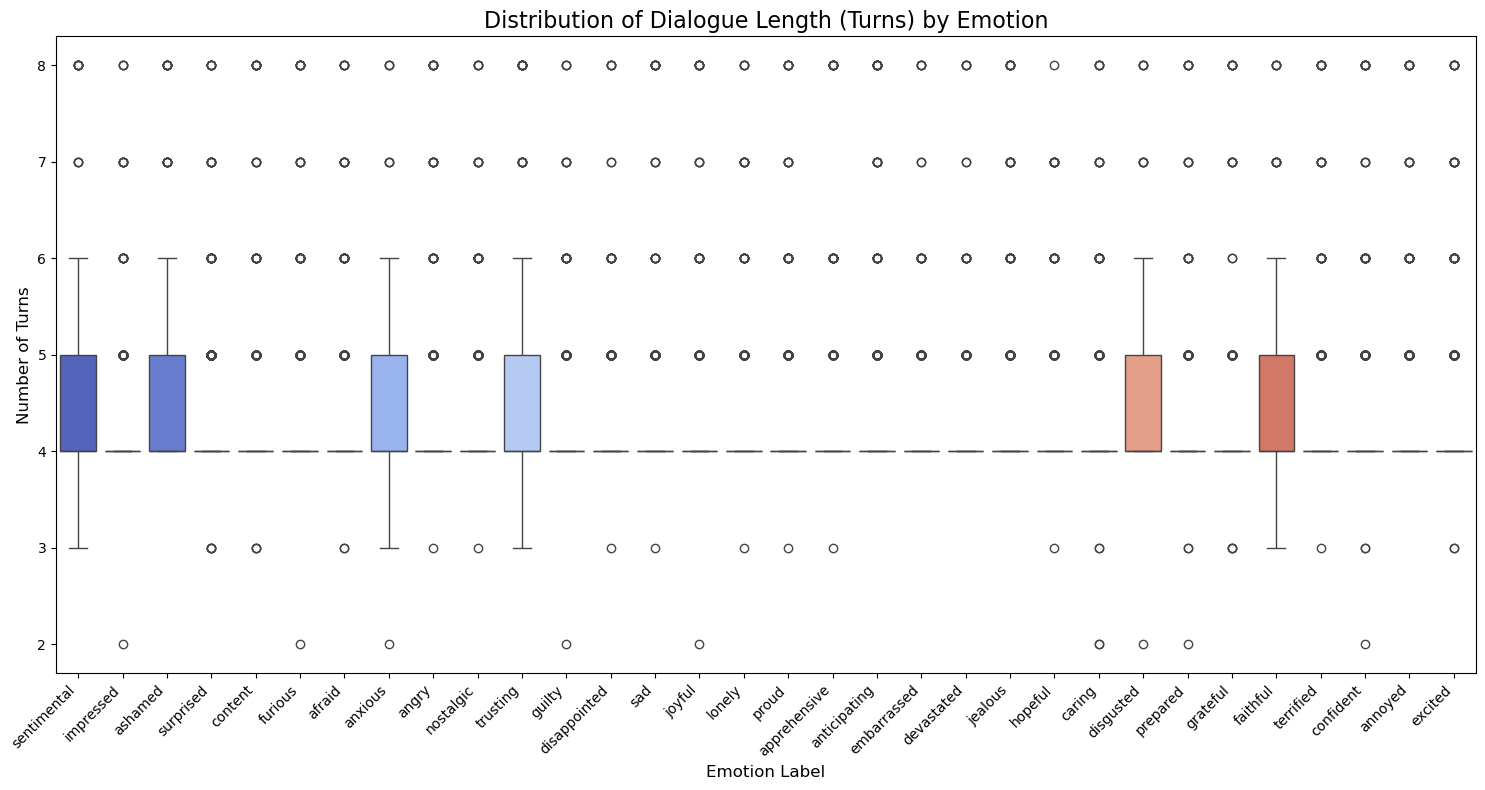

In [46]:
#will perform the EDA on train dataset
df = df_train.copy()
df.rename(columns={'context':'emotion'}, inplace=True)

#dialogue length vs emoiton
convo_lngth = df.groupby('conv_id').size()
convo_emotion_map = df.drop_duplicates(subset='conv_id').set_index('conv_id')['emotion']
lngth_emotion_df = pd.DataFrame({'length': convo_lngth, 'emotion': convo_emotion_map})

plt.figure(figsize=(15, 8))
sns.boxplot(data=lngth_emotion_df, x='emotion', y='length', palette='coolwarm')
plt.title('Distribution of Dialogue Length (Turns) by Emotion', fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Number of Turns', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
#lexical analysis (top bigrams)..
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

def getTopNgrams(corpus,n=2,top_k=5):
    tokens = nltk.word_tokenize(corpus.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    n_grams = ngrams(tokens,n)
    return Counter(n_grams).most_common(top_k)

emotions2analyze = ['proud', 'guilty', 'terrified', 'joyful']
for emotion in emotions2analyze:
    corpus = " ".join(df[df['emotion']== emotion]['utterance'].str.replace('_comma_',','))
    top_ngrams = getTopNgrams(corpus)
    formatted_ngrams = [f"'{' '.join(gram)}'" for gram, count in top_ngrams]
    print(f"Emotion:- {emotion.capitalize():<12} | Top Bigrams: {', '.join(formatted_ngrams)}")


Emotion:- Proud        | Top Bigrams: 'must proud', 'high school', 'worked hard', 'hard work', 'sounds like'
Emotion:- Guilty       | Top Bigrams: 'feel bad', 'felt bad', 'really bad', 'feel guilty', 'last night'
Emotion:- Terrified    | Top Bigrams: 'last night', 'oh wow', 'sorry hear', 'roller coaster', 'walking home'
Emotion:- Joyful       | Top Bigrams: 'sounds like', 'long time', 'happy see', 'first time', 'great time'


### ***Data Saving***

In [51]:
def preparDF(df):
    df = df.copy()
    df.rename(columns={'context':'emotion'},inplace=True)

    #groupby convo to format dialogues
    grpd = df.groupby('conv_id')

    #formating each convo
    formatted_dialogues = {}
    for name, group in tqdm(grpd, desc=f"Formatting dialogues"):
        dilg_turns = []
        for i,row in group.sort_values(by='utterance_idx').iterrows():
            speaker = f"Speaker {row['speaker_idx']}"
            utterance = str(row['utterance']).replace('_comma_',' ')
            dilg_turns.append(f"{speaker}:{utterance}")
        formatted_dialogues[name] = " | ".join(dilg_turns)

    #create the final processsed dataframe
    processed_df = df.drop_duplicates(subset='conv_id').set_index('conv_id')
    processed_df['dialogue'] = processed_df.index.map(formatted_dialogues)

    #using the 'prompt' as the target summary
    processed_df.rename(columns={'prompt':'target_summary'},inplace=True)

    #creatingg the final input text for the model
    processed_df['input_text'] = processed_df.apply(lambda row: f"emotion: {row['emotion']} dialogue: {row['dialogue']}",axis=1) 
    return processed_df[['emotion','dialogue','target_summary','input_text']].reset_index()

train_data = preparDF(df_train)
valid_data = preparDF(df_valid)
test_data = preparDF(df_test)

train_data.to_csv("../FinalDataset/trainFinal.csv",index=False)
test_data.to_csv("../FinalDataset/testFinal.csv",index=False)
valid_data.to_csv("../FinalDataset/validFinal.csv",index=False)

train_data.head()

Formatting dialogues: 100%|██████████| 1776/1776 [00:00<00:00, 8628.52it/s]


,conv_id,emotion,dialogue,target_summary,input_text
0,hit:0_conv:1,sentimental,Speaker 1:I remember going to see the firework...,I remember going to the fireworks with my best...,emotion: sentimental dialogue: Speaker 1:I rem...
1,hit:1_conv:2,afraid,Speaker 2: it feels like hitting to blank wall...,i used to scare for darkness,emotion: afraid dialogue: Speaker 2: it feels ...
2,hit:1_conv:3,proud,Speaker 3:Hi how are you doing today | Speaker...,I showed a guy how to run a good bead in weldi...,emotion: proud dialogue: Speaker 3:Hi how are ...
3,hit:2_conv:4,faithful,Speaker 4:I have never cheated on my wife. | S...,I have always been loyal to my wife.,emotion: faithful dialogue: Speaker 4:I have n...
4,hit:2_conv:5,terrified,Speaker 5:Job interviews always make me sweat ...,A recent job interview that I had made me feel...,emotion: terrified dialogue: Speaker 5:Job int...
